This notebook was made to explore the project and will have some preliminary results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from pylab import *
%matplotlib inline

$N^2 = -\frac{g}{\rho_{0}(z)}\frac{\partial \rho_{0}(z)}{\partial z}$

Assume $\rho_{0}$ = 1e3, $\frac{\partial \rho_{0}(z)}{\partial z}$ = 1e-1

Literature review of conditions for baroclinic tides:
$\frac{\sigma^2 - f^2}{N^2-\sigma^2}$~$\frac{dH}{dX}$

In [2]:
## define some constants
g = 10
ngrid =40
b0 = 400
L = 5e3
dx = L/(ngrid-1)
dz = b0/(ngrid-1)
omega =2*np.pi/(12.42*3600) ##frequency of the initial M2 barotropic tidal currents
k_t = -omega/np.sqrt(g*b0)## wavenumber in x dimension
w0 = 1e-5
#N2 = 1e-4

In [3]:
dz/dx

0.08

In [4]:
omega/(k_t*b0)

-0.15811388300841897

In [5]:
## define psi, psi_t, psi_c, H, x and z grid points
psi = np.zeros((ngrid,ngrid))
psi_t = np.zeros((ngrid,ngrid))
psi_c = np.zeros((ngrid,ngrid))
H = b0*np.ones((ngrid,ngrid))
#x = np.arange(ngrid)
#z= np.flipud(x)
#x,z = np.meshgrid(x,z)

In [6]:
def bathy1(b0, ngrid):
    ## construct slope topography
    for i in np.arange(ngrid):
        H[i,:] = -i*b0/(ngrid-1)   
    m = np.zeros_like(H)
    for i in np.arange(ngrid/2,ngrid,1):
        j = i-20
        m[i:, j] = 1
    ## mask the slope bathymetry
    Hm = np.ma.masked_array(H, m)
    #Hm[(ngrid-1)/2,0] = Hm[(ngrid-1)/2,1]
    #Hm[0,(ngrid-1)/2] = Hm[0,(ngrid-1)/2+1]
    Hm = np.flipud(Hm)

    return Hm

In [7]:
Hm = bathy1(b0,ngrid)

In [8]:
## define slope of the topography
#x_slope = np.arange(ngrid/2)
#z_slope = np.flipud(np.arange(ngrid/2))
## define x,y_slope corner of the topography
#x_slope_corner = np.delete(x_slope, -1)
#z_slope_corner = z_slope+1
#z_slope_corner = np.delete(z_slope_corner, -1)
##append the corner points and slope points
#x_x = np.append(x_slope,x_slope_corner)
#z_z = np.append(z_slope,z_slope_corner)

(0, 40)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


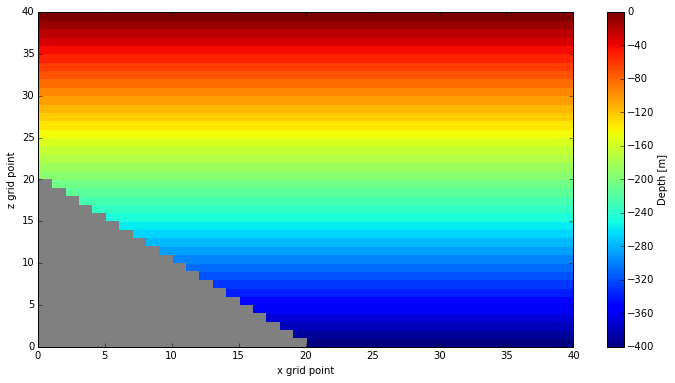

In [9]:
fig, ax =plt.subplots(1,1,figsize = (12,6))
plot=ax.pcolormesh(Hm,linewidth=0,rasterized=True, vmin = -400, vmax= 0)
cbar= plt.colorbar(plot)
cbar.set_label('Depth [m]')
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    ax.add_patch(rec[i])

ax.set_xlim(0,40)
ax.set_xlabel('x grid point')
ax.set_ylabel('z grid point')
ax.set_ylim(0,40)

In [10]:
def initial_conditions(psi_c):
    """Set the initial condition values when x=0.
    """
    psi_c[:,0] = 0 ## left vertical wall
    ## the first x point:
    psi_c[-1+ngrid/2:,1] = 0
    #-(1/omega)*np.sqrt(g*b0)* np.sin(k_t*np.pi*1/180) * (b0+Hm[-1+ngrid/2:,-1])/b0
    ## for slope boundary points:
    a= np.loadtxt('slope_index.txt')
    for i in np.arange(len(a)):
        psi_c[a[i,0],a[i,1]] = -(w0/k_t)* np.sin(k_t*np.pi*a[i,1]*dx/180) * (b0+Hm[a[i,0],-1])/b0
    return psi_c

In [11]:
def boundary_conditions(psi_c):
    """Set the boundary condition values.
    """
    ## three fixed boundary
    psi_c[-1,:] = 0## surface wall(rigid lib)## surface wall(rigid lib)
    psi_c[-1+ngrid/2:,0] = 0 ## left vertical wall
    psi_c[0,-1+ngrid/2:] = 0 ## bottom wall
    #-(1/omega)*np.sqrt(g*b0)* np.sin(k_t*180*np.arange(-1+ngrid/2,40,1)/np.pi)*(b0+Hm[0,-1])/b0 ## bottom wall
    return psi_c

In [12]:
def leap_frog(psi_c, N2):
    """Calculate the next x (or i) values using the leap-frog scheme.
    
    """
    ## This loop is for the whole domain
    a= np.loadtxt('slope_index.txt')
    for i in np.arange(1,ngrid-1,1):##i range from 1 to 38
        for pz in np.arange(1, ngrid-1,1):## pz range from 1 to 38
            psi_c[pz, i+1] = 2*psi_c[pz, i] + (dx**2/N2[pz,i])*(omega**2*(psi_c[pz-1,i]-2*psi_c[pz,i]\
            +psi_c[pz+1,i])/(dz**2)-(N2[pz,i]/g)*omega**2*(psi_c[pz-1,i]-psi_c[pz+1,i])/(2*dz)) - psi_c[pz, i-1]
            for item in np.arange(len(a)):
                if (pz== a[item,0]) & ((i+1) ==a[item,1]):
                    psi_c[pz, i+1] = -(w0/k_t)* np.sin(k_t*np.pi*(i+1)*dx/180)*(b0+Hm[pz,-1])/b0
    
    return psi_c   

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


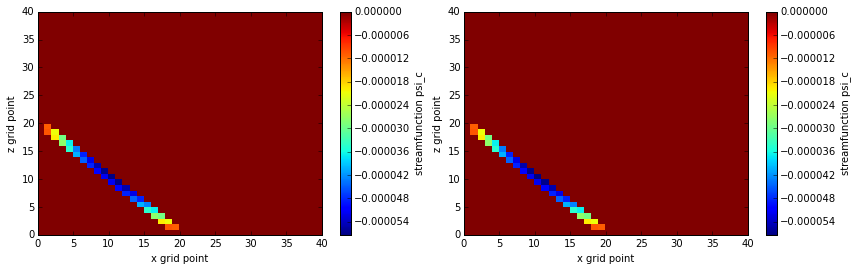

In [13]:
fig, axs =plt.subplots(1,2,figsize = (14,4))
psi_c = initial_conditions(psi_c)
plot1= axs[0].pcolormesh(psi_c,linewidth=0,rasterized=True,cmap = 'jet')
cbar = fig.colorbar(plot1, ax=axs[0])
cbar.set_label('streamfunction psi_c')
#axs[0].set_title('initial condition')
psi_c = boundary_conditions(psi_c)
plot2=axs[1].pcolormesh(psi_c,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot2, ax=axs[1])
cbar.set_label('streamfunction psi_c')
#axs[1].set_title('boundary condition')
for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point')
    ax.set_ylabel('z grid point')
    ax.set_ylim(0,40)

# First case: N2 = const

In [14]:
## after leap frog
N2= np.zeros([ngrid,ngrid])
N2[:] = 5e-6
psi_c = leap_frog(psi_c,N2)

In [15]:
mask = Hm.mask
psi_c = np.ma.array(psi_c,mask =mask)

In [16]:
## barotropic streamfunction
psi_t = (w0/k_t)* np.sin(k_t*np.pi*np.arange(0,40,1)*dx/180) * (b0+Hm)/b0

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


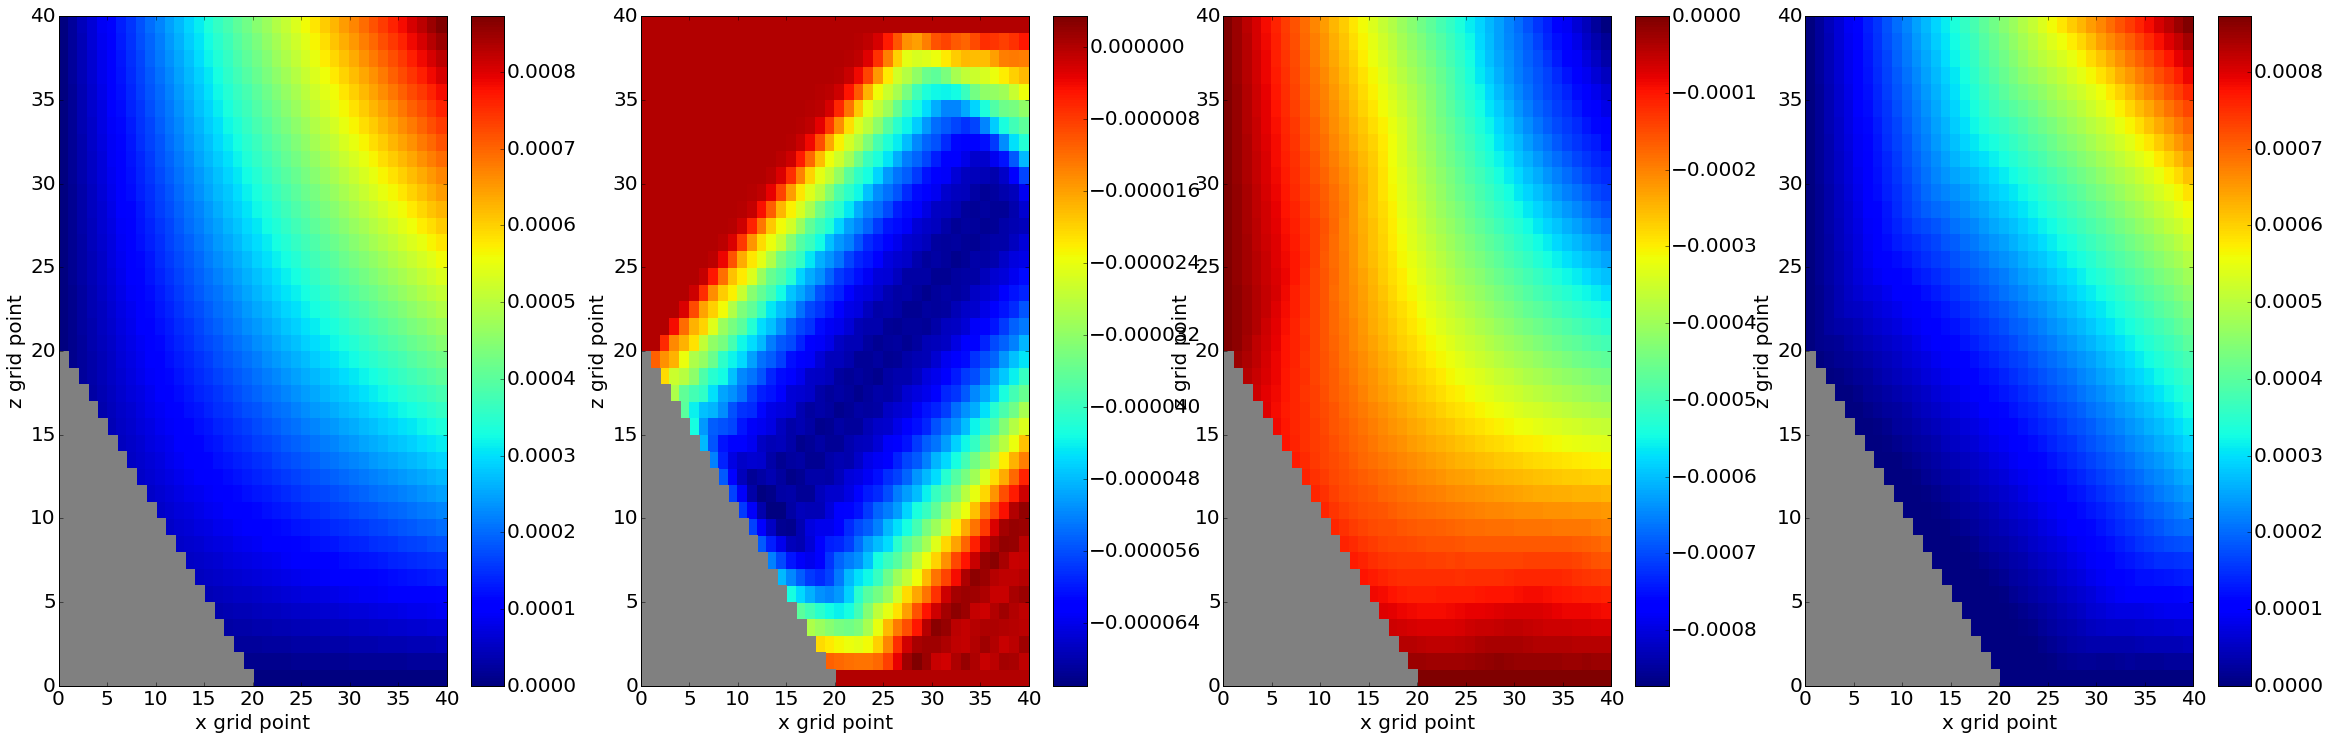

In [17]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[0])
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[0].add_patch(rec[i])
#cbar.set_label('streamfunction psi_t', fontsize = 20)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
#axs[0].set_title('barotropic streamfunction psi_t')

plot=axs[1].pcolormesh(psi_c,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[1].add_patch(rec[i])
#cbar.set_label('streamfunction psi_c', fontsize = 20)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
#axs[1].set_title('baroclinic streamfunction psi_c')

plot=axs[2].pcolormesh(psi_c-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[2].add_patch(rec[i])
#cbar.set_label('difference of between psi_c and psi_t', fontsize = 20)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
#axs[2].set_title('psi_c - psi_t')

plot=axs[3].pcolormesh(psi_c+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[3].add_patch(rec[i])
#cbar.set_label('difference of between psi_c and psi_t', fontsize = 20)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
#axs[3].set_title('psi_c + psi_t')

for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point', fontsize = 20)
    ax.set_ylabel('z grid point', fontsize = 20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

In [18]:
## CFL condition
magnitude_u = (w0/k_t)* 1* 1/b0
cfl = dz/(dx*magnitude_u)
if np.abs(cfl) >1:
    print ('cfl condition satisfied')

cfl condition satisfied


* It becomes suddenly unstable when N2 = 1e-06 with current sets even with cfl condition satisfied.

# Analytical solution

The analytical solution for $\psi_c$ is $\psi_c = \exp(\frac{N^2}{2g}z)\sin\sqrt{\frac{N^2k_{c}^2}{\sigma^2}-\frac{N^4}{4g^2}z}\exp(ik_{c}x)$

In [17]:
##define analytical solution psi_ca
psi_ca = np.zeros([ngrid,ngrid])

* M2 internal wave length scale = $N_{0}HT/\pi$. (Pereira, A. F., et al. )

In [18]:
##based on that paper
l_s = np.sqrt(N2)*b0*2*np.pi/(omega*np.pi)
k_c = 2*np.pi/l_s;
N2 = 1e-4

In [19]:
for i in np.arange(0,ngrid,1):##(0,40) no 40
    for pz in np.arange(ngrid-1, -1,-1):##(39,-1) no -1
        psi_ca[pz,i] = np.exp(N2*Hm[pz,-1]/(2*g))*np.sin(np.sqrt(N2*k_c**2/omega**2-N2**2/(4*g**2))*Hm[pz,-1])\
        *np.cos(k_c*i*dx*np.pi/180)

ValueError: setting an array element with a sequence.

In [ ]:
plt.pcolormesh(psi_ca)
plt.colorbar()

# different stratification

Gonna to use N2 from NEMO model result and by employing inverse distance interpolation vertically, to calculate the N2 for my model.

* summer stratification

In [17]:
n2_su = np.loadtxt("n2summer.txt")
dep = np.loadtxt('nemodepth.txt')

In [18]:
idws = []
for i in np.arange(40):
    for j in np.arange(40):
        if (-Hm[i,-1] >= dep[j]) and (-Hm[i,-1] <= dep[j+1]):
            idw = (n2_su[j]/ np.abs(dep[j]+Hm[i,-1]) + n2_su[j+1]/ np.abs(dep[j+1]+Hm[i,-1]))\
             /(1/ np.abs(dep[j]+Hm[i,-1])+1/ np.abs(dep[j+1]+Hm[i,-1]))
            idws.append(idw)

In [19]:
idws.append(0.00001)
len(idws)

40

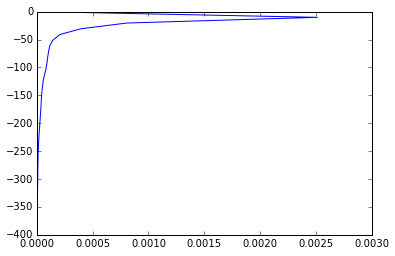

In [20]:
plt.plot(idws, Hm[:,-1])

In [21]:
## inverse distance weighting interpolation
n2_orig = []; n2=[]
for i in -Hm[:,-1]:
    n2_orig = np.sum(n2_su*1/np.abs(i-dep))/np.sum(1/np.abs(i-dep))
    n2.append(n2_orig)

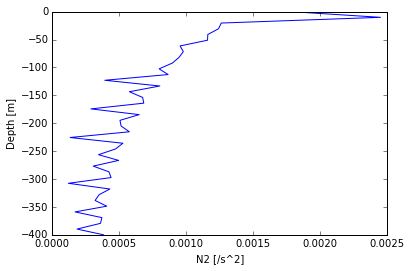

In [22]:
## does not look good >.<
plt.plot(n2, Hm[:,-1])
plt.xlabel('N2 [/s^2]')
plt.ylabel('Depth [m]')

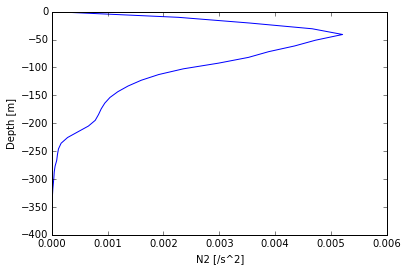

In [23]:
## what about just plotting the n2_su versus depth
plt.plot(n2_su, np.flipud(Hm[:,-1]))
plt.xlabel('N2 [/s^2]')
plt.ylabel('Depth [m]')

In [24]:
## put the stratification in the whole model domain
n2_domain = np.zeros([ngrid,ngrid])
for i in np.arange(ngrid):
    n2_domain[:,i] = idws
    n2_domain[:,i] = n2_domain[:,i]

In [25]:
## after leap frog
psi_c = np.zeros((ngrid,ngrid))
psi_c = initial_conditions(psi_c)
psi_c = boundary_conditions(psi_c)
psi_c = leap_frog(psi_c,n2_domain)
mask = Hm.mask
psi_c = np.ma.array(psi_c,mask =mask)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


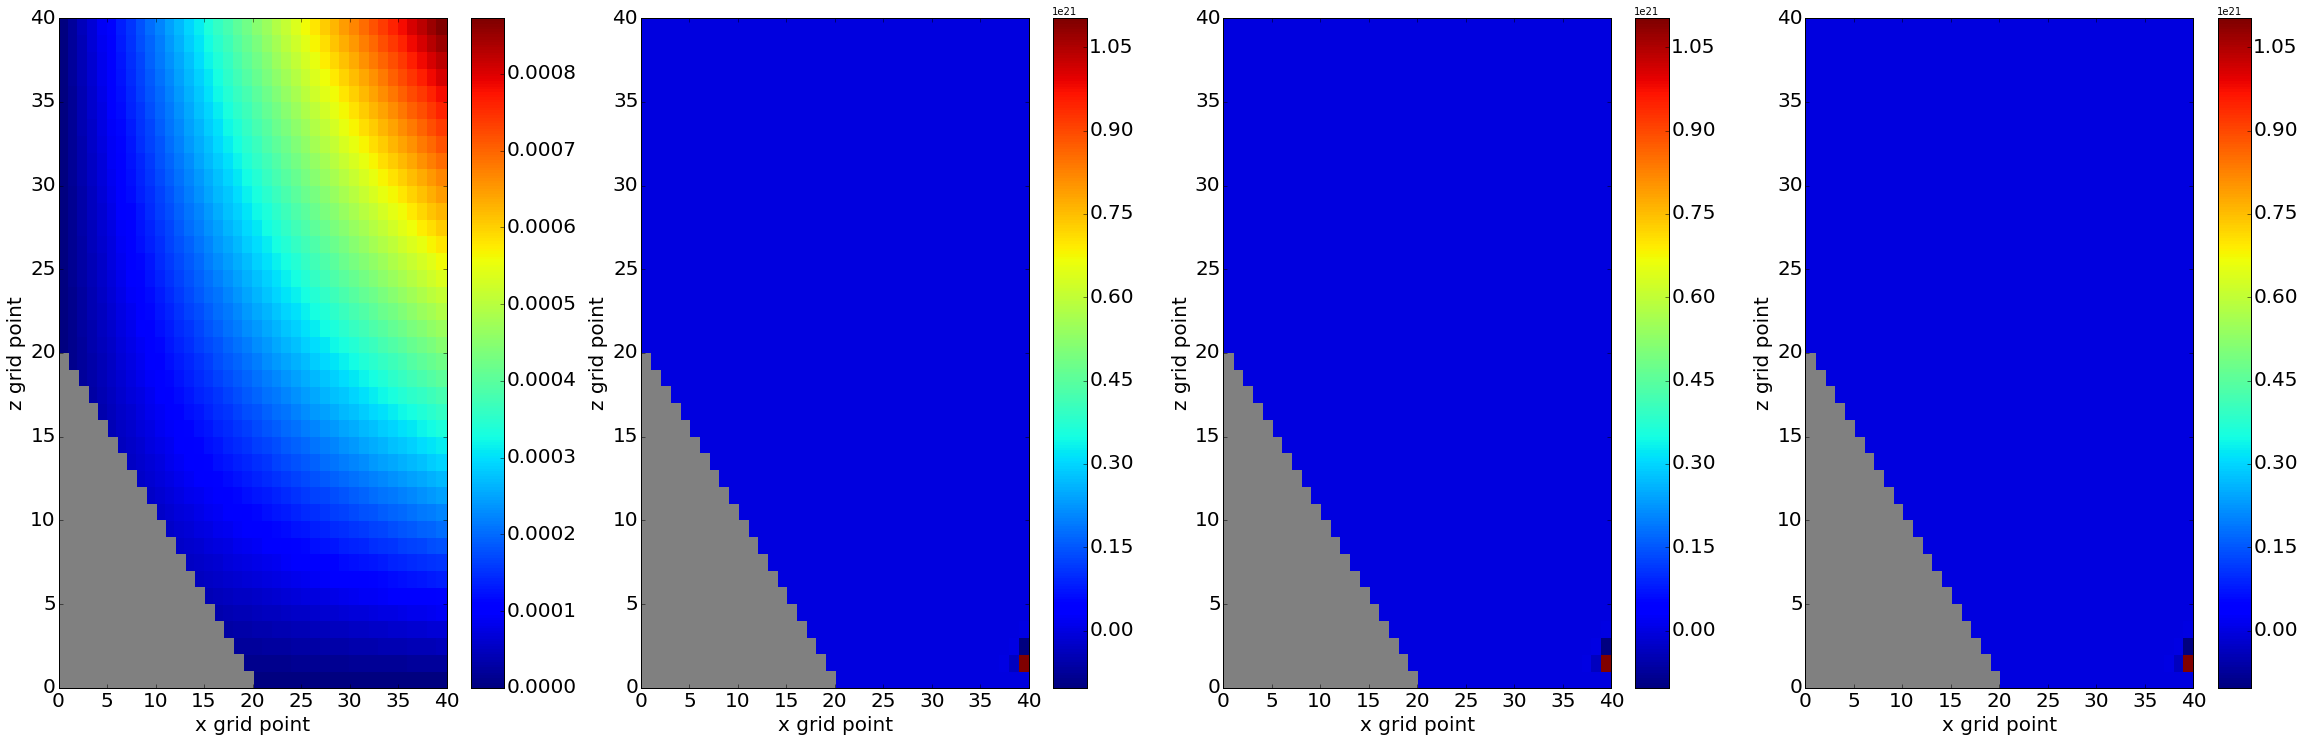

In [26]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[0])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))
for i in np.arange(20):
    axs[0].add_patch(rec[i])
#axs[0].set_title('barotropic streamfunction psi_t')

plot=axs[1].pcolormesh(psi_c,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[1].add_patch(rec[i])
#axs[1].set_title('baroclinic streamfunction psi_c')

plot=axs[2].pcolormesh(psi_c-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[2].add_patch(rec[i])
#axs[2].set_title('psi_c - psi_t')

plot=axs[3].pcolormesh(psi_c+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[3].add_patch(rec[i])
#axs[3].set_title('psi_c + psi_t')

for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point', fontsize = 20)
    ax.set_ylabel('z grid point', fontsize = 20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

* winter stratification

In [24]:
n2_su = np.loadtxt("n2winter.txt")
dep = np.loadtxt('nemodepth.txt')

In [25]:
idws = []
for i in np.arange(40):
    for j in np.arange(40):
        if (-Hm[i,-1] >= dep[j]) and (-Hm[i,-1] <= dep[j+1]):
            idw = (n2_su[j]/ np.abs(dep[j]+Hm[i,-1]) + n2_su[j+1]/ np.abs(dep[j+1]+Hm[i,-1]))\
             /(1/ np.abs(dep[j]+Hm[i,-1])+1/ np.abs(dep[j+1]+Hm[i,-1]))
            idws.append(idw)
idws.append(0.001)

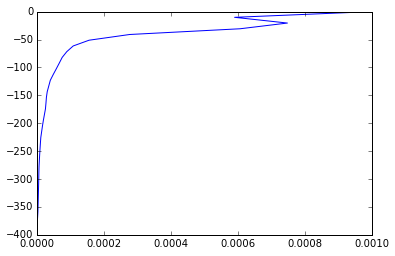

In [26]:
plt.plot(idws, Hm[:,-1])

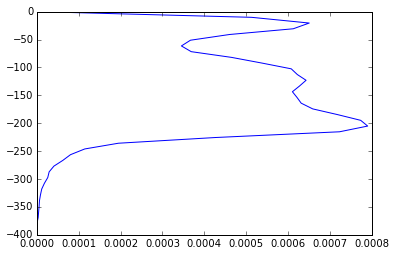

In [27]:
plt.plot(n2_su, np.flipud(Hm[:,-1]))

In [33]:
## put the stratification in the whole model domain
n2_domain = np.zeros([ngrid,ngrid])
for i in np.arange(ngrid):
    n2_domain[:,i] = idws
    n2_domain[:,i] = n2_domain[:,i]*10

In [34]:
## after leap frog
psi_c = np.zeros((ngrid,ngrid))
psi_c = initial_conditions(psi_c)
psi_c = boundary_conditions(psi_c)
psi_c = leap_frog(psi_c,n2_domain)
mask = Hm.mask
psi_c = np.ma.array(psi_c,mask =mask)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


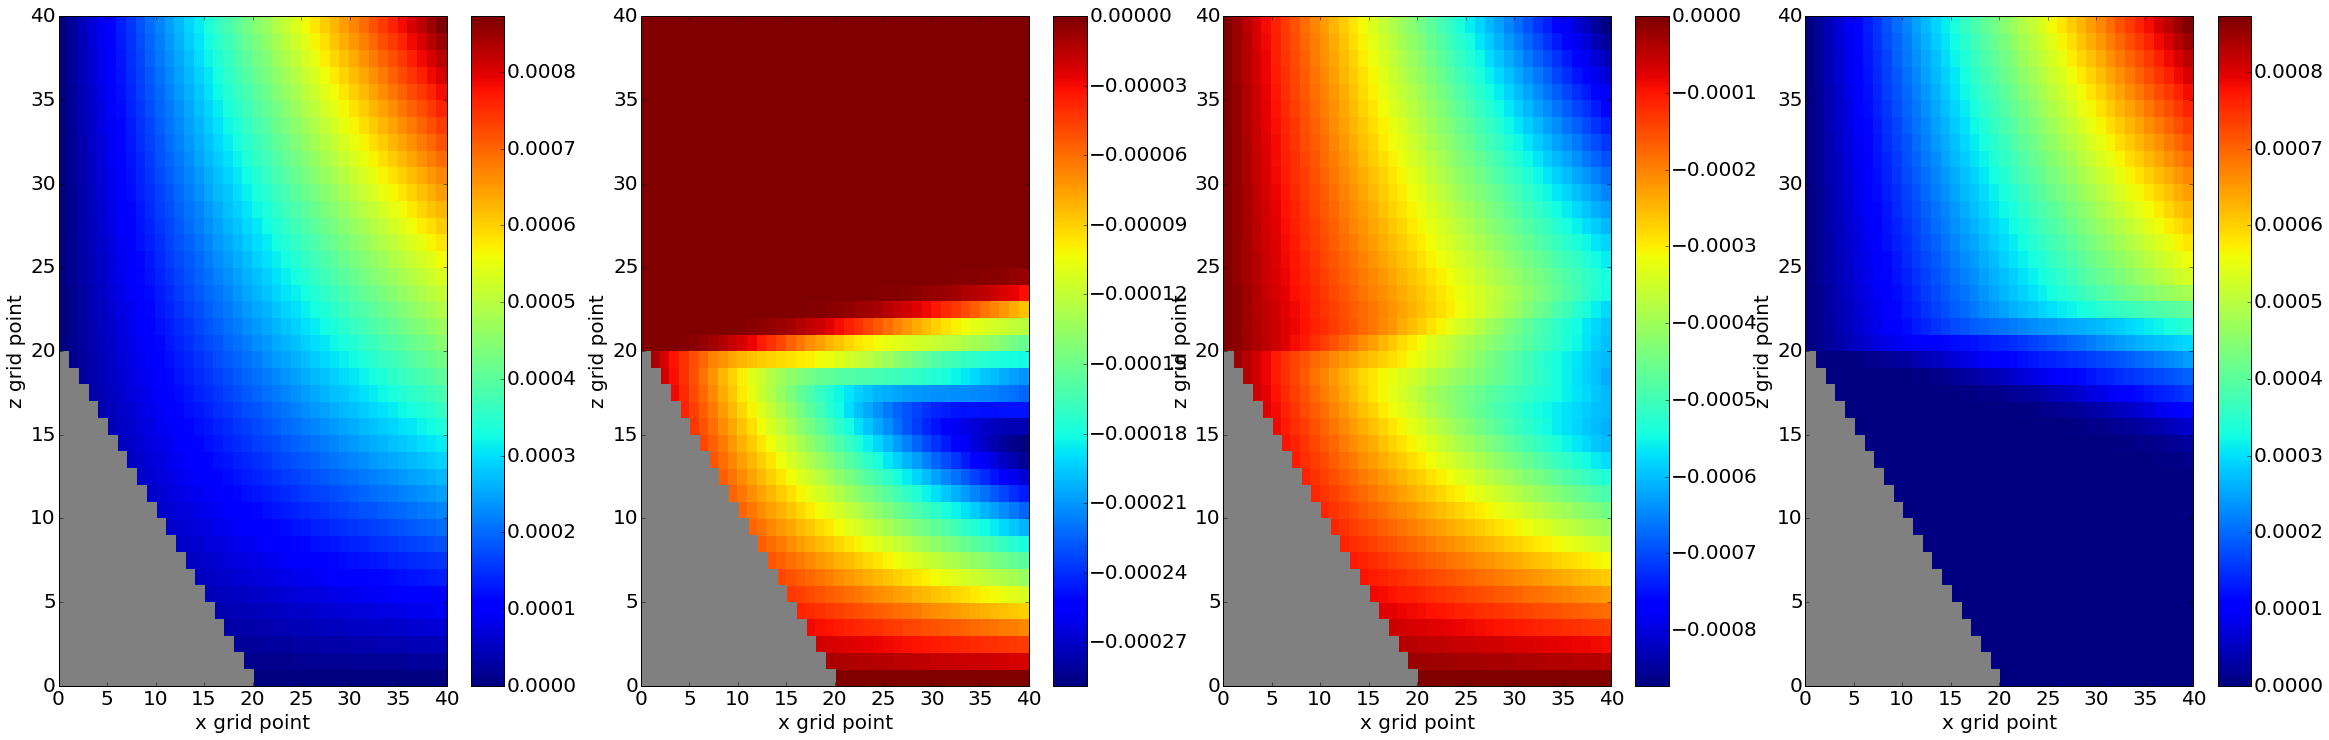

In [36]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[0])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[0].add_patch(rec[i])

plot=axs[1].pcolormesh(psi_c,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[1].add_patch(rec[i])

plot=axs[2].pcolormesh(psi_c-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[2].add_patch(rec[i])


plot=axs[3].pcolormesh(psi_c+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
rec = []
for i in np.arange(ngrid/2):
    rec.append(patches.Rectangle((0,i), 20-i, 1, color='gray'))

for i in np.arange(20):
    axs[3].add_patch(rec[i])
#axs[3].set_title('psi_c + psi_t')

for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point', fontsize = 20)
    ax.set_ylabel('z grid point', fontsize = 20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

In [46]:
np.sqrt(omega**2/(1e-7-omega**2))

0.49605109810997594

In [45]:
omega/(k_t*b0)

-0.15811388300841897

In [46]:
10/125

0.08

In [44]:
n2_domain[:,-1]

array([  1.57740105e-05,   2.69054087e-05,   1.14706767e-04,
         2.22727712e-04,   3.20004464e-04,   3.63210250e-04,
         4.06416037e-04,   4.50334733e-04,   4.94859155e-04,
         5.39383576e-04,   5.74770410e-04,   6.09322939e-04,
         6.60420982e-04,   7.51324057e-04,   8.42227133e-04,
         9.48215757e-04,   1.06150105e-03,   1.18276518e-03,
         1.42819575e-03,   1.67362632e-03,   1.94887531e-03,
         2.25935878e-03,   2.56984226e-03,   2.72292684e-03,
         2.85427565e-03,   3.09871777e-03,   3.56150214e-03,
         4.02428652e-03,   4.88757181e-03,   5.80444642e-03,
         6.69799788e-03,   7.57330850e-03,   8.94142115e-03,
         1.08717685e-02,   1.55921723e-02,   2.77365001e-02,
         6.06795321e-02,   7.48447028e-02,   5.90679666e-02,
         1.00000000e-01])

# Try Bathymetry 2

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.patches as patches
from pylab import *

In [19]:
## define some constants
g = 10
ngrid =40
b0 = 400
L = 5e3
dx = L/(ngrid-1)
dz = b0/(ngrid-1)
omega =2*np.pi/(12.42*3600) ##frequency of the initial M2 barotropic tidal currents
k_t = - omega/np.sqrt(g*b0)## wavenumber in x dimension
w0 = 1e-5

In [20]:
## define psi, psi_t, psi_c, H, x and z grid points
psi = np.zeros((ngrid,ngrid))
psi_t = np.zeros((ngrid,ngrid))
psi_c = np.zeros((ngrid,ngrid))
H = b0*np.ones((ngrid,ngrid))
#x = np.arange(ngrid)
#z= np.flipud(x)
#x,z = np.meshgrid(x,z)

In [21]:
def bathy2(b0, ngrid):
    ## construct step topography
    H = b0*np.ones((ngrid,ngrid))
    for i in np.arange(ngrid):
        H[i,:] = -i*b0/(ngrid-1)   
    m = np.zeros_like(H)
    m[0:ngrid/2,0:ngrid/2]=1
    ## mask the step bathymetry
    H = np.flipud(H)
    Hm = np.ma.masked_array(H, m)

    return Hm

In [22]:
Hm2= bathy2(b0,ngrid)

(0, 40)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


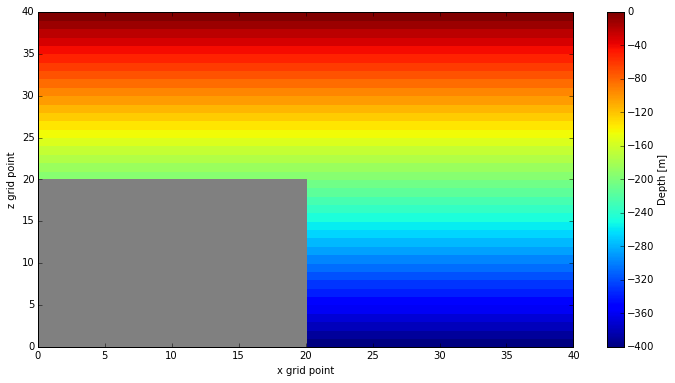

In [23]:
fig, ax =plt.subplots(1,1,figsize = (12,6))
plot = ax.pcolormesh(Hm2,linewidth=0,rasterized=True, vmin = -400, vmax= 0)
cbar= plt.colorbar(plot)
ax.pcolormesh(Hm2,linewidth=0,rasterized=True, vmin = -400, vmax= 0)
rect = patches.Rectangle((0,0), 20, 20, color='gray')

ax.add_patch(rect)
cbar.set_label('Depth [m]')
#ax.grid('on')
ax.set_xlim(0,40)
ax.set_xlabel('x grid point')
ax.set_ylabel('z grid point')
ax.set_ylim(0,40)

In [24]:
def initial_conditions2(psi_c2):
    ## the first x point
    psi_c2[-1+ngrid/2:,1] = 0
    ## the first z point
    #psi_c2[-2,:] =  
    ## read in barotropic tides at the horizontal step
    psi_c2[-1+ngrid/2,:ngrid/2] = -(w0/k_t)* np.sin(k_t*np.pi*np.arange(0,ngrid/2,1)*dx/180)*\
                (b0+Hm2[-1+ngrid/2,-1])/b0
    ## read in barotropic tides at the vertical step
    psi_c2[:ngrid/2,-1+ngrid/2] = -(w0/k_t)* np.sin(k_t*np.pi*(-1+ngrid/2)*dx/180)*\
                (b0+Hm2[:ngrid/2,-1])/b0
    return psi_c2

In [25]:
def boundary_conditions2(psi_c2):
    psi_c2[-1,:] = 0## surface wall(rigid lib)## surface wall(rigid lib)
    psi_c2[-1+ngrid/2:,0] = 0 ## left vertical wall
    psi_c2[0,-1+ngrid/2:] = 0 ## bottom wall
    return psi_c2

In [26]:
def leap_frog2(psi_c, N2):
    """Calculate the next x (or i) values using the leap-frog scheme.
    
    """
    ## This loop is for the whole domain
    a= np.loadtxt('step_index.txt')
    for i in np.arange(1,ngrid-1,1):##i range from 1 to 38
        for pz in np.arange(1, ngrid-1,1):## pz range from 1 to 38
            if i==1 and pz ==38:
                print(psi_c[pz, i+1])
            psi_c[pz, i+1] = 2*psi_c[pz, i] + (dx**2/N2[pz,i])*(omega**2*(psi_c[pz-1,i]-2*psi_c[pz,i]\
            +psi_c[pz+1,i])/(dz**2)-(N2[pz,i]/g)*omega**2*(psi_c[pz+1,i]-psi_c[pz-1,i])/(2*dz)) - psi_c[pz, i-1]
            
            if pz==38 and i==2:
                print ('psi_c[38,2] is :', psi_c[pz,i])
            if pz==19 and i==2:
                print ('psi_c[19,2] is :', psi_c[pz,i])
            for item in np.arange(len(a)):
                if (pz== a[item,0]) & ((i+1) ==a[item,1]):
                    psi_c[pz, i+1] = -(w0/k_t)* np.sin(k_t*np.pi*(i+1)*dx/180)*(b0+Hm2[pz,-1])/b0
            #if i==1 and pz ==2:
                #print (2*psi_c[pz, i])
                #print ((dx**2/N2[pz,i])*(omega**2*(psi_c[pz-1,i]-2*psi_c[pz,i]\
            #+psi_c[pz+1,i])/(dz**2)))
                #print ((N2[pz,i]/g)*omega**2*(psi_c[pz+1,i]-psi_c[pz-1,i])/(2*dz))
                #print (psi_c[pz, i-1])
            #print(psi_c[pz, i+1])
               
    return psi_c   

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


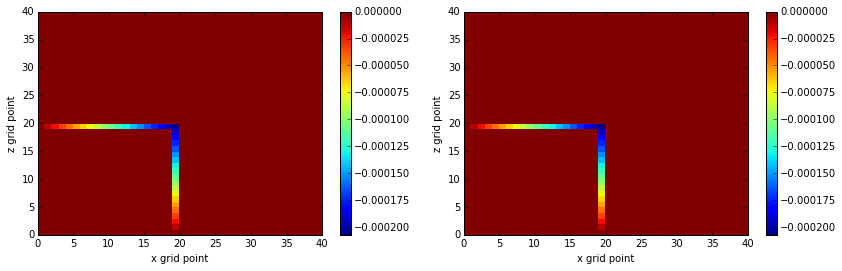

In [27]:
psi_c2 = np.zeros((ngrid,ngrid))
fig, axs =plt.subplots(1,2,figsize = (14,4))
psi_c2 = initial_conditions2(psi_c2)
plot1= axs[0].pcolormesh(psi_c2,linewidth=0,rasterized=True,cmap = 'jet')
cabr = fig.colorbar(plot1, ax=axs[0])
cbar.set_label('streamfunction psi_c2')
#axs[0].set_title('initial condition')
psi_c2 = boundary_conditions2(psi_c2)
plot2=axs[1].pcolormesh(psi_c2,linewidth=0,rasterized=True,cmap = 'jet')
cabr = fig.colorbar(plot2, ax=axs[1])
cbar.set_label('streamfunction psi_c2')
#axs[1].set_title('boundary condition')
for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point')
    ax.set_ylabel('z grid point')
    ax.set_ylim(0,40)

In [28]:
## after leap frog
N2= np.zeros([ngrid,ngrid])
N2[:] = 5e-5
psi_c2 = leap_frog2(psi_c2,N2)
psi_c2[19,3]

0.0
psi_c[19,2] is : -2.18022720495e-05
psi_c[38,2] is : 0.0


-3.2703408073631888e-05

In [29]:
mask = Hm2.mask
psi_c2 = np.ma.array(psi_c2,mask =mask)
psi_t = (w0/k_t)* np.sin(k_t*np.pi*np.arange(0,40,1)*dx/180) * (b0+Hm2)/b0

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


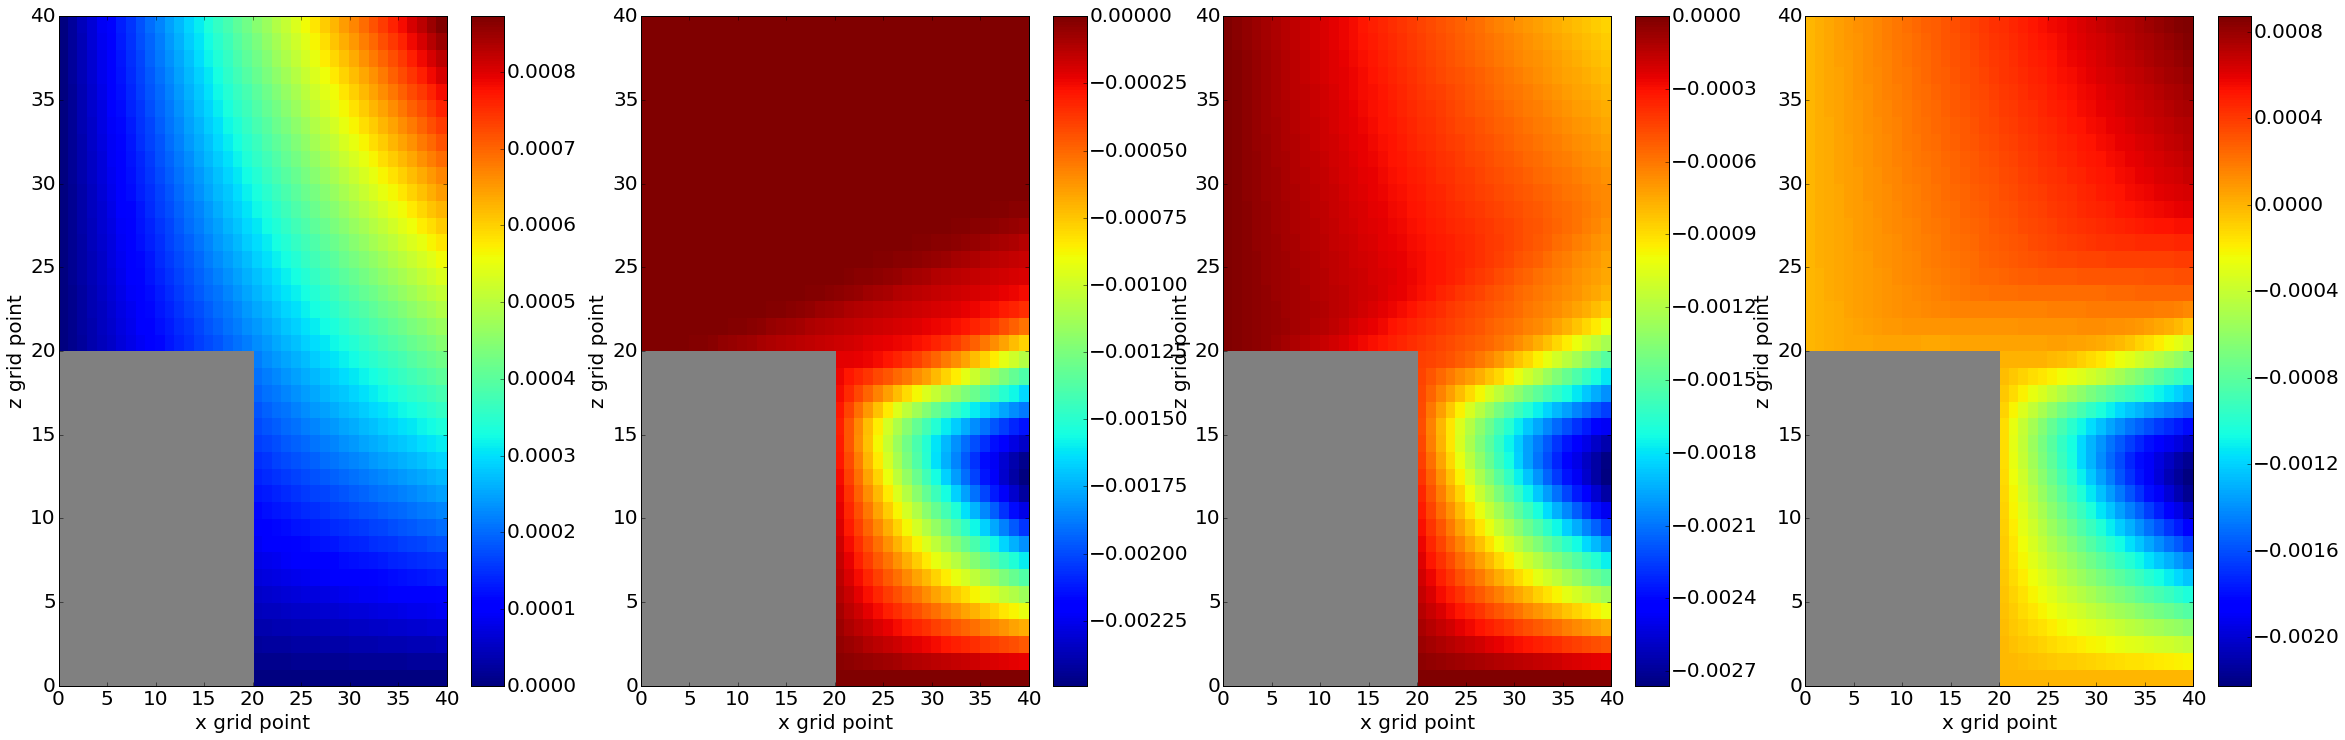

In [43]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar= fig.colorbar(plot, ax=axs[0])
axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[0].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[1].pcolormesh(psi_c2,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[1].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[2].pcolormesh(psi_c2-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[2].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  



plot=axs[3].pcolormesh(psi_c2+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[3].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point',fontsize=20 )
    ax.set_ylabel('z grid point',fontsize=20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

* summer stratification

In [32]:
mask = Hm2.mask
psi_c2 = np.ma.array(psi_c2,mask =mask)
psi_t = (w0/k_t)* np.sin(k_t*np.pi*np.arange(0,40,1)*dx/180) * (b0+Hm2)/b0
## after leap frog
psi_c2 = np.zeros((ngrid,ngrid))
psi_c2 = initial_conditions2(psi_c2)
psi_c2 = boundary_conditions2(psi_c2)
psi_c2 = leap_frog2(psi_c2,n2_domain)
psi_c2 = np.ma.array(psi_c2,mask =mask)

0.0
psi_c[19,2] is : -2.18022720495e-05
psi_c[38,2] is : 0.0


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


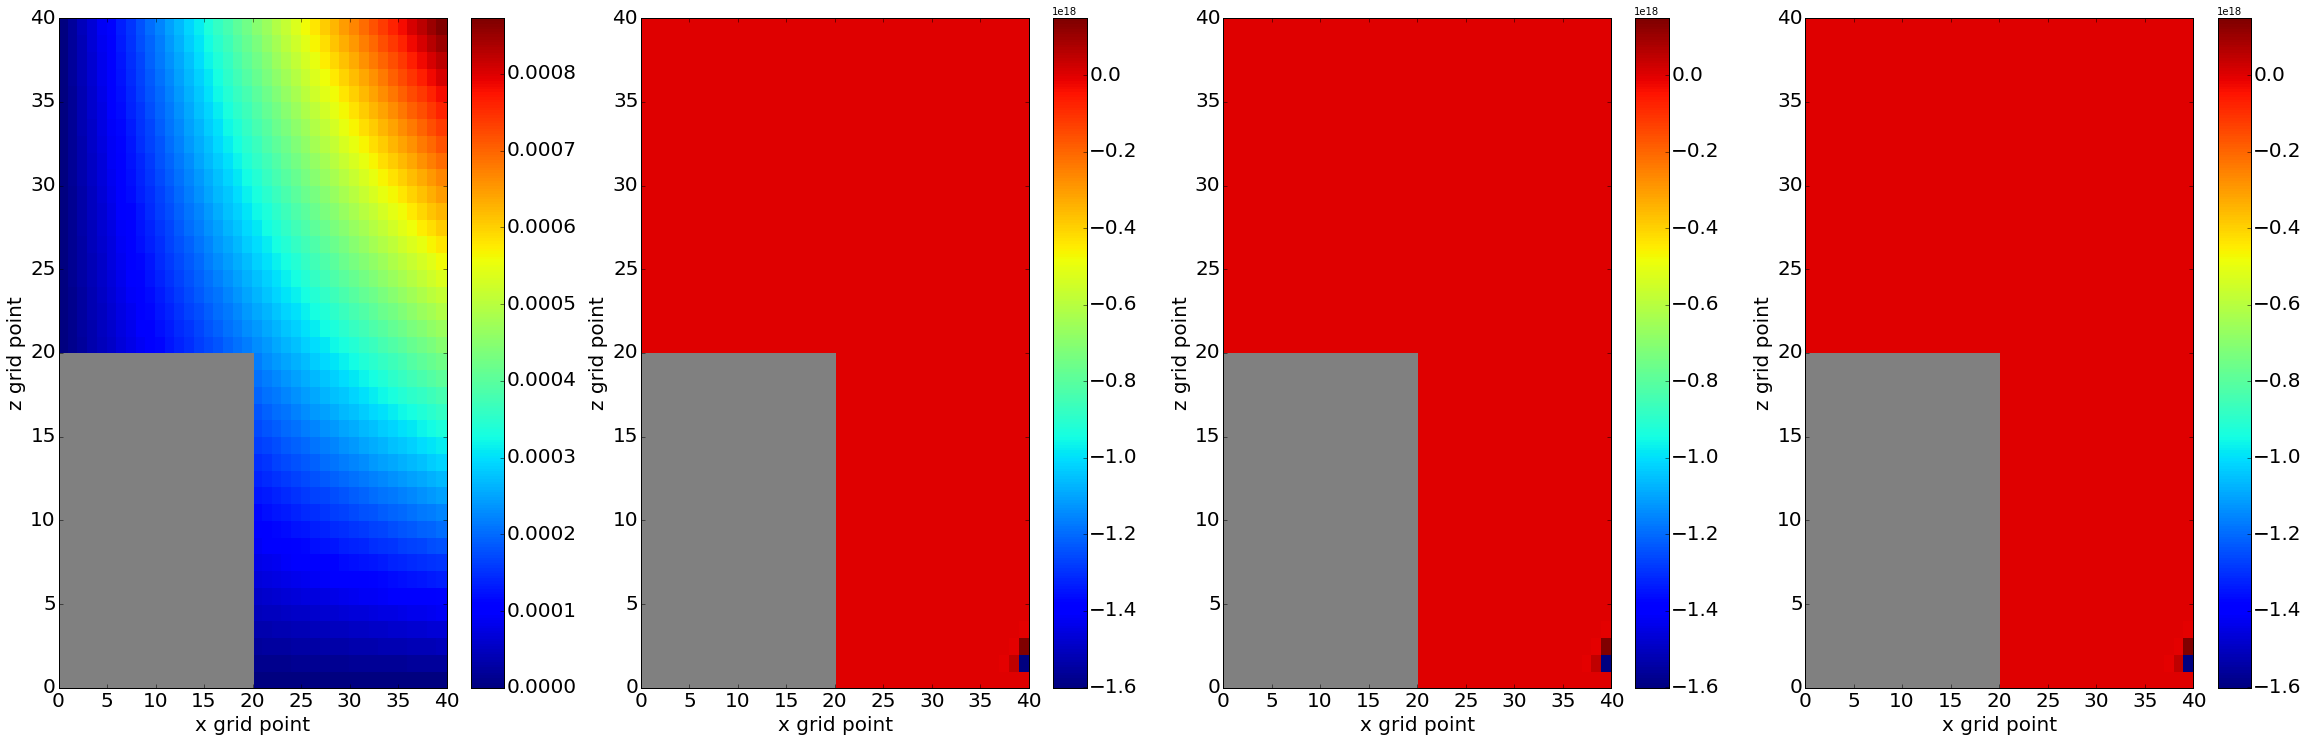

In [33]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[0])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[0].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[1].pcolormesh(psi_c2,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[1].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  


plot=axs[2].pcolormesh(psi_c2-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[2].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[3].pcolormesh(psi_c2+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[3].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  


for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point', fontsize = 20)
    ax.set_ylabel('z grid point', fontsize = 20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

* winter stratification

In [39]:
n2_su = np.loadtxt("n2winter.txt")
dep = np.loadtxt('nemodepth.txt')

In [40]:
idws = []
for i in np.arange(40):
    for j in np.arange(40):
        if (-Hm2[i,-1] >= dep[j]) and (-Hm2[i,-1] <= dep[j+1]):
            idw = (n2_su[j]/ np.abs(dep[j]+Hm[i,-1]) + n2_su[j+1]/ np.abs(dep[j+1]+Hm[i,-1]))\
             /(1/ np.abs(dep[j]+Hm2[i,-1])+1/ np.abs(dep[j+1]+Hm2[i,-1]))
            idws.append(idw)
idws.append(0.001)

In [41]:
## put the stratification in the whole model domain
n2_domain = np.zeros([ngrid,ngrid])
for i in np.arange(ngrid):
    n2_domain[:,i] = idws
    n2_domain[:,i] = n2_domain[:,i]*10

In [42]:
mask = Hm2.mask
psi_c2 = np.ma.array(psi_c2,mask =mask)
psi_t = (w0/k_t)* np.sin(k_t*np.pi*np.arange(0,40,1)*dx/180) * (b0+Hm2)/b0
## after leap frog
psi_c2 = np.zeros((ngrid,ngrid))
psi_c2 = initial_conditions2(psi_c2)
psi_c2 = boundary_conditions2(psi_c2)
psi_c2 = leap_frog2(psi_c2,n2_domain)
psi_c2 = np.ma.array(psi_c2,mask =mask)

0.0
psi_c[19,2] is : -2.18022720495e-05
psi_c[38,2] is : 0.0


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


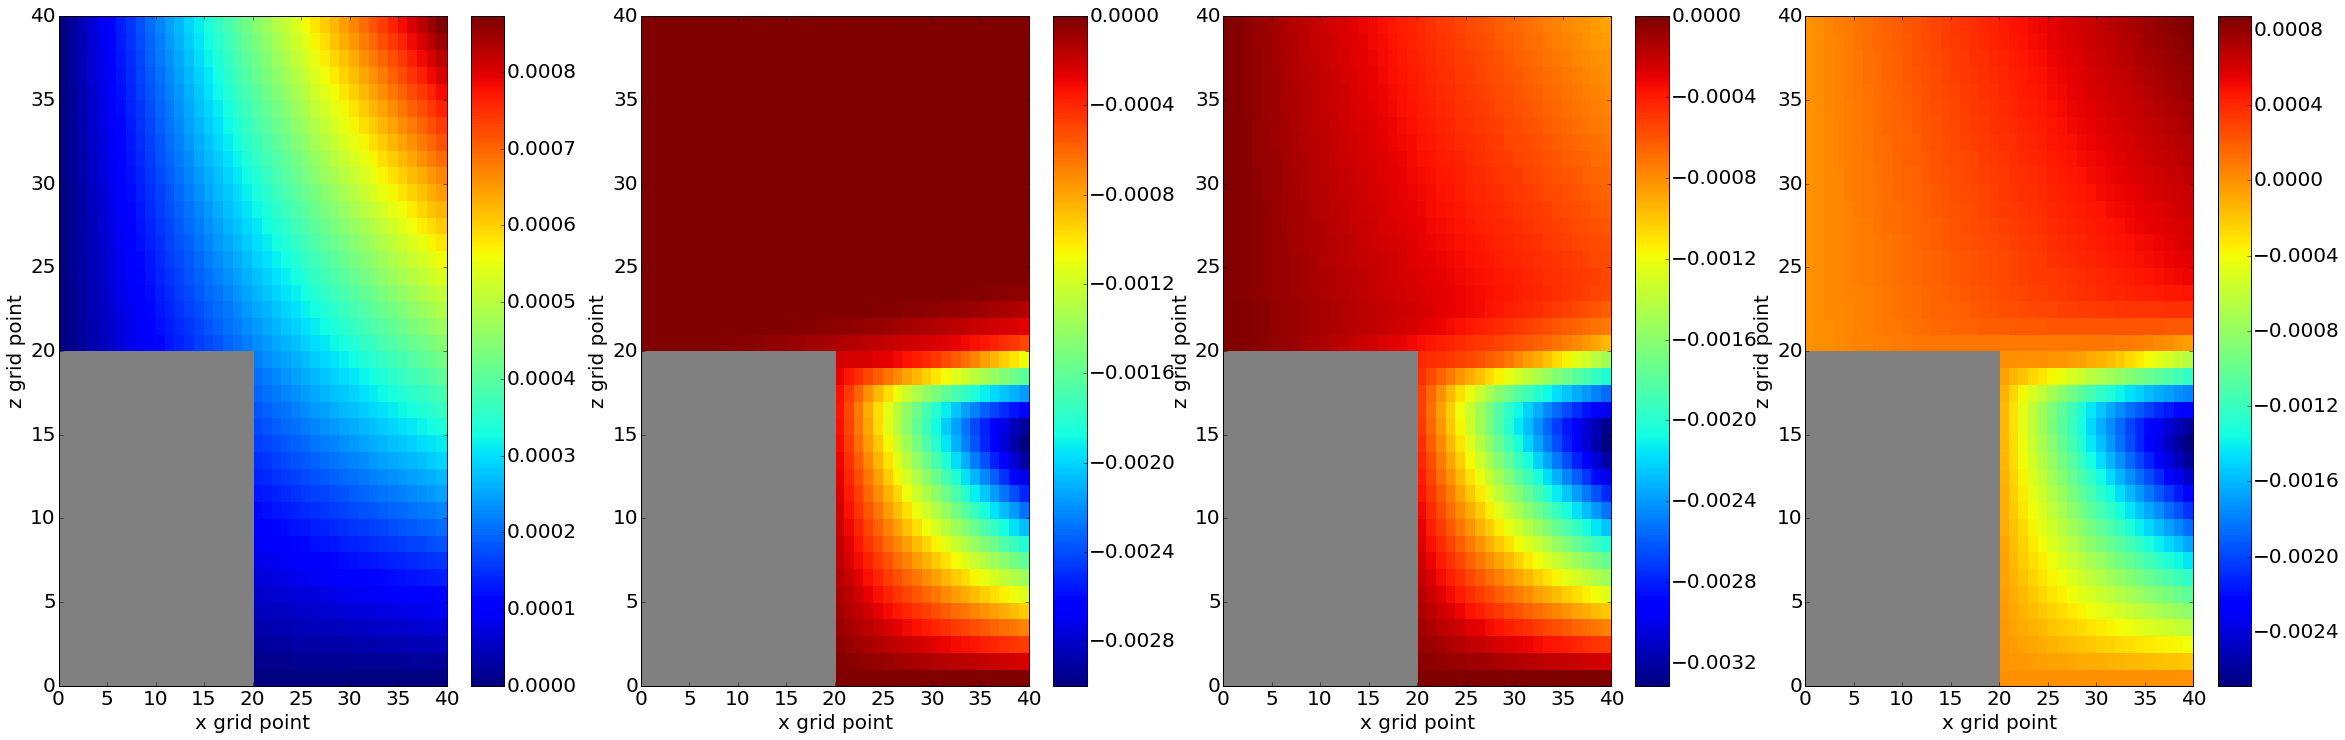

In [43]:
fig, axs =plt.subplots(1,4,figsize = (40,12))
## barotropic inputs
plot=axs[0].pcolormesh(psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[0])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[0].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[1].pcolormesh(psi_c2,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[1])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[1].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  


plot=axs[2].pcolormesh(psi_c2-psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[2])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[2].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  

plot=axs[3].pcolormesh(psi_c2+psi_t,linewidth=0,rasterized=True,cmap = 'jet')
cbar=fig.colorbar(plot, ax=axs[3])
rect = patches.Rectangle((0,0), 20, 20, color='gray')
axs[3].add_patch(rect)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  


for ax in axs:
    ax.set_xlim(0,40)
    ax.set_xlabel('x grid point', fontsize = 20)
    ax.set_ylabel('z grid point', fontsize = 20)
    ax.set_ylim(0,40)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)